# before replacement

In [ ]:
import pandas
import matplotlib.pyplot as plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

In [ ]:
before_water_data = pandas.read_csv('./waterinfo/cleaned_before.csv')

# datetime object maken van datetime
before_water_data['datetime'] = pandas.to_datetime(before_water_data['datetime'])

# verwijderen van undercarriage_replacement, aangezien die gelijk is voor de hele dataset
before_water_data = before_water_data.drop('undercarriage_replacement', axis=1)

In [ ]:
def create_lag_features(df, feature, lag, step_size):
    for i in range(1, lag + 1):
        if (i - 1) % step_size == 0:
            df[f'{feature}_lag_{i}'] = df[feature].shift(i)
    df = df.dropna()  # wegja halen van de NaN waardes door het shiften van de data
    return df

In [ ]:
before_water_data = create_lag_features(before_water_data, 'water_level_cmNAP', 6, 2)
before_water_data = create_lag_features(before_water_data, 'air_temperature_01C', 3, 1)
before_water_data

In [ ]:
# vervangt lock movement met boolean, zodat het gebruikt wordt door ons model
before_water_data.lock_movement = before_water_data['lock_movement'].replace('closing', 0)
before_water_data.lock_movement = before_water_data['lock_movement'].replace('opening', 1)

# eerste datum
min_date = before_water_data['datetime'].iloc[0]

# aantal dagen sinds die dag
before_water_data['days_since_first_measurement'] = (before_water_data['datetime'] - min_date).dt.days

In [ ]:
# functie om datetime object om te zetten naar variabelen
# tijdens het testen bleek dit niet niet voor verbetering te zorgen
def addDates(df):
  # df['day'] = df.datetime.dt.day
  # df['month'] = df.datetime.dt.month
  # df['year'] = df.datetime.dt.year
  # df['hour'] = df.datetime.dt.hour
  # df['minute'] = df.datetime.dt.minute
  return df

before_water_data = addDates(before_water_data)


In [ ]:
# de correlatie van onze numerieke data
whole_corr = before_water_data.select_dtypes(include=['float64', 'int64', 'int32']).corr()

In [ ]:
import seaborn

plot.figure(figsize=(10, 8))

# plot de heatmap
seaborn.heatmap(whole_corr, annot=True, cmap='coolwarm')

# laat de plot zien
plot.show()

In [ ]:
# alleen numerieke data gebruiken
numeric_features = before_water_data.select_dtypes(include=[float, int]).columns
before_water_data = before_water_data[numeric_features]


# dataframe opsplitsen in features en target
X = before_water_data.drop(['energy_proxy'], axis=1)
y = before_water_data['energy_proxy']

# dataframe opsplitsen in train en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X


In [ ]:
# de parameters voor de randomforest regressor
param_grid = {
    'n_estimators': [600],
    'max_depth': [10, 12],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [4, 6]
}

# de randomForestRegressor
random_forest_regressor = RandomForestRegressor(random_state=42)

# grid search
grid_search = GridSearchCV(estimator=random_forest_regressor, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# pak beste estimator/ combinatie van parameters
best_rf = grid_search.best_estimator_

# voorspel met beste estimator
y_pred = best_rf.predict(X_test)

# bereken de scores
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print de scores
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validate: {-cv_scores}")


In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# werkt alleen als de kolommen een list zijn
feature_names = X.columns.tolist()

# de boom visualiseren
plt.figure(figsize=(20, 10))
plot_tree(best_rf.estimators_[0], feature_names=feature_names, filled=True, rounded=True)
plt.show()

In [ ]:
# Scatter plot
plot.scatter(y_pred, y_test, alpha=0.4)

# diagonale lijn
plot.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], color='red', alpha=0.5)

# Labels en titel
plot.xlabel('Predicted values')
plot.ylabel('Actual values')
plot.title('Scatter plot of Predicted vs Actual values')

# laat de plot zien
plot.show()

In [ ]:
# feature importance van beste estimator
feature_importances = best_rf.feature_importances_
features = X_train.columns

# het maken van een dataframe om de feature importance te plotten
importance_df = pandas.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# sorteren op importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plot.figure(figsize=(10, 8))
seaborn.barplot(x='Importance', y='Feature', data=importance_df)
plot.title('Feature Importance')
plot.show()


# after replacement

In [ ]:
import pandas
import matplotlib.pyplot as plot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score


In [ ]:
after_water_data = pandas.read_csv('./waterinfo/cleaned_after.csv')

# datetime object maken van datetime
after_water_data['datetime'] = pandas.to_datetime(after_water_data['datetime'])

# verwijderen van undercarriage_replacement, aangezien die gelijk is voor de hele dataset
after_water_data = after_water_data.drop('undercarriage_replacement', axis=1)


In [ ]:
def create_lag_features(df, feature, lag, step_size):
    for i in range(1, lag + 1):
        if (i - 1) % step_size == 0:
            df[f'{feature}_lag_{i}'] = df[feature].shift(i)
    df = df.dropna()  # wegja halen van de NaN waardes door het shiften van de data
    return df


In [ ]:
after_water_data = create_lag_features(after_water_data, 'water_level_cmNAP', 6, 2)
after_water_data = create_lag_features(after_water_data, 'water_temperature_C', 3, 1)
after_water_data


In [ ]:
# vervangt lock movement met boolean, zodat het gebruikt wordt door ons model
after_water_data.lock_movement = after_water_data['lock_movement'].replace('closing', 0)
after_water_data.lock_movement = after_water_data['lock_movement'].replace('opening', 1)

# eerste datum
min_date = after_water_data['datetime'].iloc[0]

# aantal dagen sinds die dag
after_water_data['days_since_first_measurement'] = (after_water_data['datetime'] - min_date).dt.days
after_water_data


In [ ]:
# functie om datetime object om te zetten naar variabelen
# tijdens het testen bleek dit niet niet voor verbetering te zorgen
def addDates(df):
  # df['day'] = df.datetime.dt.day
  # df['month'] = df.datetime.dt.month
  # df['year'] = df.datetime.dt.year
  # df['hour'] = df.datetime.dt.hour
  # df['minute'] = df.datetime.dt.minute
  return df


In [ ]:

after_water_data = addDates(after_water_data)

In [ ]:

# de correlatie van onze numerieke data
whole_corr = after_water_data.select_dtypes(include=['float64', 'int64', 'int32']).corr()


In [ ]:
import seaborn

plot.figure(figsize=(10, 8))

# plot de heatmap
seaborn.heatmap(whole_corr, annot=True, cmap='coolwarm')

# laat de plot zien
plot.show()

In [ ]:
# alleen numerieke data gebruiken
numeric_features = after_water_data.select_dtypes(include=[float, int]).columns
after_water_data = after_water_data[numeric_features]


# dataframe opsplitsen in features en target
X = after_water_data.drop(['energy_proxy', 'air_temperature_01C'], axis=1)
y = after_water_data['energy_proxy']

# dataframe opsplitsen in train en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X


In [ ]:

# de parameters voor de randomforest regressor
param_grid = {
    'n_estimators': [600],
    'max_depth': [10, 12],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [4, 6]
}

# de randomForestRegressor
random_forest_regressor = RandomForestRegressor(random_state=42)

# grid search
grid_search = GridSearchCV(estimator=random_forest_regressor, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# pak beste estimator/ combinatie van parameters
best_rf = grid_search.best_estimator_

# voorspel met beste estimator
y_pred = best_rf.predict(X_test)

# bereken de scores
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print de scores
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validate: {-cv_scores}")



In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# werkt alleen als de kolommen een list zijn
feature_names = X.columns.tolist()

# de boom visualiseren
plt.figure(figsize=(20, 10))
plot_tree(best_rf.estimators_[0], feature_names=feature_names, filled=True, rounded=True)
plt.show()


In [ ]:
# Scatter plot
plot.scatter(y_pred, y_test, alpha=0.3)

# diagonale lijn
plot.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], color='red', alpha=0.5)

# Labels en titel
plot.xlabel('Predicted values')
plot.ylabel('Actual values')
plot.title('Scatter plot of Predicted vs Actual values')

# laat de plot zien
plot.show()


In [ ]:
# feature importance van beste estimator
feature_importances = best_rf.feature_importances_
features = X_train.columns

# het maken van een dataframe om de feature importance te plotten
importance_df = pandas.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# sorteren op importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plot.figure(figsize=(10, 8))
seaborn.barplot(x='Importance', y='Feature', data=importance_df)
plot.title('Feature Importance')
plot.show()

# all data

In [2]:
import pandas
import matplotlib.pyplot as plot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score


In [4]:
all_water_data = pandas.read_csv('./cleaned_all.csv')

# datetime object maken van datetime
all_water_data['datetime'] = pandas.to_datetime(all_water_data['datetime'])
all_water_data


,file_name,datetime,lock_movement,undercarriage_replacement,water_temperature_C,water_level_cmNAP,air_temperature_01C,energy_proxy
0,DVS1ZP_Converted/20200706_131712.txt,2020-07-06 13:17:12,closing,0,18.1,19.0,13.8,3044749.0
1,DVS1ZP_Converted/20200706_173238.txt,2020-07-06 17:32:38,opening,0,18.2,198.0,13.8,3795221.0
2,DVS1ZP_Converted/20200706_190034.txt,2020-07-06 19:00:34,opening,0,18.7,73.0,13.8,3681963.0
3,DVS1ZP_Converted/20200706_202747.txt,2020-07-06 20:27:47,opening,0,18.5,-41.0,13.8,3563955.0
4,DVS1ZP_Converted/20200706_211903.txt,2020-07-06 21:19:03,opening,0,18.0,-97.0,13.8,3651022.0
...,...,...,...,...,...,...,...,...
6142,DVS1ZP_Converted/20230815_000205.txt,2023-08-15 00:02:05,opening,1,20.3,-14.0,12.4,2679450.0
6143,DVS1ZP_Converted/20230815_034130.txt,2023-08-15 03:41:30,opening,1,20.2,171.0,12.4,2680340.0
6144,DVS1ZP_Converted/20230815_045959.txt,2023-08-15 04:59:59,opening,1,20.1,92.0,12.4,2791437.0
6145,DVS1ZP_Converted/20230815_064418.txt,2023-08-15 06:44:18,opening,1,20.1,-14.0,12.4,2629123.0


In [5]:

def create_lag_features(df, feature, lag, step_size):
    for i in range(1, lag + 1):
        if (i - 1) % step_size == 0:
            df[f'{feature}_lag_{i}'] = df[feature].shift(i)
    df = df.dropna()  # wegja halen van de NaN waardes door het shiften van de data
    return df


In [6]:

all_water_data = create_lag_features(all_water_data, 'water_level_cmNAP', 6, 2)
all_water_data


,file_name,datetime,lock_movement,undercarriage_replacement,water_temperature_C,water_level_cmNAP,air_temperature_01C,energy_proxy,water_level_cmNAP_lag_1,water_level_cmNAP_lag_3,water_level_cmNAP_lag_5
5,DVS1ZP_Converted/20200706_222343.txt,2020-07-06 22:23:43,opening,0,18.4,-135.0,13.8,3691449.0,-97.0,73.0,19.0
6,DVS1ZP_Converted/20200707_001401.txt,2020-07-07 00:14:01,opening,0,17.8,-95.0,14.5,3810539.0,-135.0,-41.0,198.0
7,DVS1ZP_Converted/20200707_055057.txt,2020-07-07 05:50:57,opening,0,17.2,175.0,14.5,3862124.0,-95.0,-97.0,73.0
8,DVS1ZP_Converted/20200707_065228.txt,2020-07-07 06:52:28,opening,0,17.1,90.0,14.5,3815951.0,175.0,-135.0,-41.0
9,DVS1ZP_Converted/20200707_084303.txt,2020-07-07 08:43:03,opening,0,18.7,-40.0,14.5,3551977.0,90.0,-95.0,-97.0
...,...,...,...,...,...,...,...,...,...,...,...
6142,DVS1ZP_Converted/20230815_000205.txt,2023-08-15 00:02:05,opening,1,20.3,-14.0,12.4,2679450.0,-85.0,-136.0,-49.0
6143,DVS1ZP_Converted/20230815_034130.txt,2023-08-15 03:41:30,opening,1,20.2,171.0,12.4,2680340.0,-14.0,-96.0,-92.0
6144,DVS1ZP_Converted/20230815_045959.txt,2023-08-15 04:59:59,opening,1,20.1,92.0,12.4,2791437.0,171.0,-85.0,-136.0
6145,DVS1ZP_Converted/20230815_064418.txt,2023-08-15 06:44:18,opening,1,20.1,-14.0,12.4,2629123.0,92.0,-14.0,-96.0


In [7]:

# vervangt lock movement met boolean, zodat het gebruikt wordt door ons model
all_water_data.lock_movement = all_water_data['lock_movement'].replace('closing', 0)
all_water_data.lock_movement = all_water_data['lock_movement'].replace('opening', 1)

min_date = all_water_data[all_water_data['undercarriage_replacement'].diff() == 1].index[0]

# aantal dagen verschil tussen dag en dag van onderstel vervanging
all_water_data['date difference'] = (all_water_data['datetime'] - all_water_data.datetime[min_date]).dt.days
all_water_data.tail()


C:\Users\erjbr\AppData\Local\Temp\ipykernel_24940\1344207082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_water_data.lock_movement = all_water_data['lock_movement'].replace('closing', 0)
C:\Users\erjbr\AppData\Local\Temp\ipykernel_24940\1344207082.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_water_data.lock_movement = all_water_data['lock_movement'].replace('opening', 1)
C:\Users\erjbr\AppData\Local\Temp\ipykernel_24940\1344207082.py:3: SettingWithCopyWarning: 
A value is trying to be set on a cop

,file_name,datetime,lock_movement,undercarriage_replacement,water_temperature_C,water_level_cmNAP,air_temperature_01C,energy_proxy,water_level_cmNAP_lag_1,water_level_cmNAP_lag_3,water_level_cmNAP_lag_5,date difference
6142,DVS1ZP_Converted/20230815_000205.txt,2023-08-15 00:02:05,1,1,20.3,-14.0,12.4,2679450.0,-85.0,-136.0,-49.0,458
6143,DVS1ZP_Converted/20230815_034130.txt,2023-08-15 03:41:30,1,1,20.2,171.0,12.4,2680340.0,-14.0,-96.0,-92.0,458
6144,DVS1ZP_Converted/20230815_045959.txt,2023-08-15 04:59:59,1,1,20.1,92.0,12.4,2791437.0,171.0,-85.0,-136.0,458
6145,DVS1ZP_Converted/20230815_064418.txt,2023-08-15 06:44:18,1,1,20.1,-14.0,12.4,2629123.0,92.0,-14.0,-96.0,458
6146,DVS1ZP_Converted/20230815_082212.txt,2023-08-15 08:22:12,1,1,20.1,-99.0,12.4,2935750.0,-14.0,171.0,-85.0,458


In [8]:

# functie om datetime object om te zetten naar variabelen
# tijdens het testen bleek dit niet niet voor verbetering te zorgen
def addDates(df):
  # df['day'] = df.datetime.dt.day
  # df['month'] = df.datetime.dt.month
  # df['year'] = df.datetime.dt.year
  # df['hour'] = df.datetime.dt.hour
  # df['minute'] = df.datetime.dt.minute
  return df

all_water_data = addDates(all_water_data)


In [9]:

# de correlatie van onze numerieke data
whole_corr = all_water_data.select_dtypes(include=['float64', 'int64', 'int32']).corr()


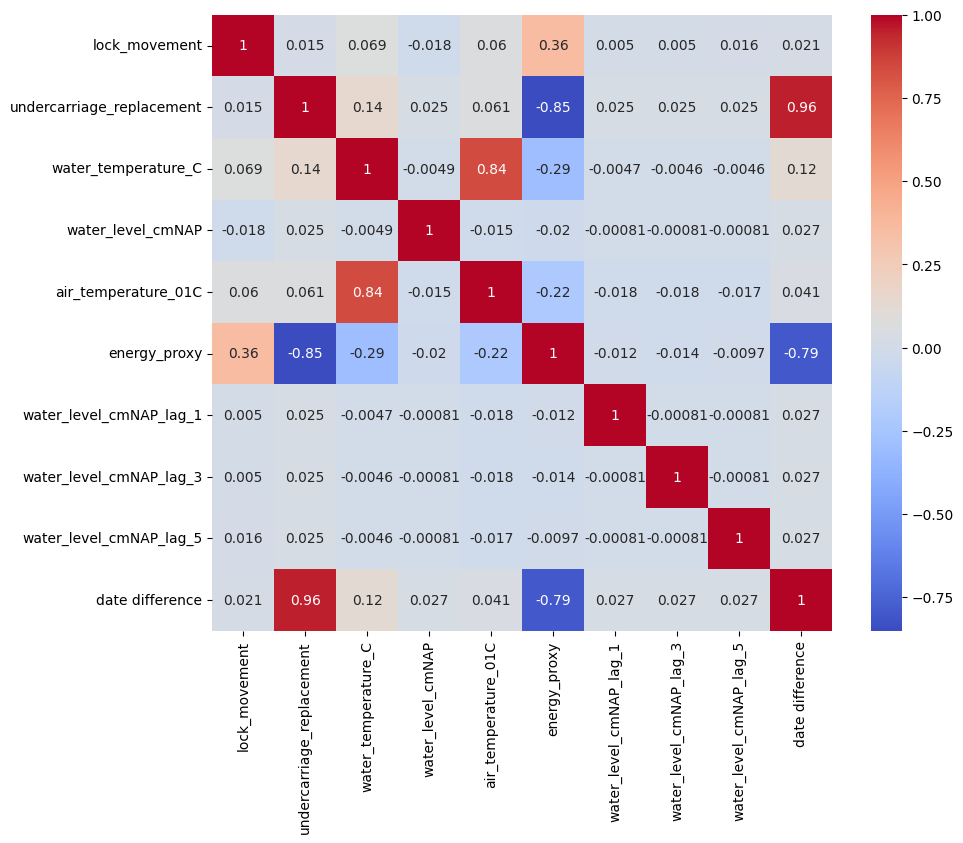

In [10]:
import seaborn
plot.figure(figsize=(10, 8))

# plot de heatmap
seaborn.heatmap(whole_corr, annot=True, cmap='coolwarm')

# laat de plot zien
plot.show()


In [11]:

# alleen numerieke data gebruiken
numeric_features = all_water_data.select_dtypes(include=[float, int]).columns
all_water_data = all_water_data[numeric_features]


# dataframe opsplitsen in features en target
X = all_water_data.drop(['energy_proxy'], axis=1)
y = all_water_data['energy_proxy']

# dataframe opsplitsen in train en test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X


,lock_movement,undercarriage_replacement,water_temperature_C,water_level_cmNAP,air_temperature_01C,water_level_cmNAP_lag_1,water_level_cmNAP_lag_3,water_level_cmNAP_lag_5,date difference
5,1,0,18.4,-135.0,13.8,-97.0,73.0,19.0,-676
6,1,0,17.8,-95.0,14.5,-135.0,-41.0,198.0,-676
7,1,0,17.2,175.0,14.5,-95.0,-97.0,73.0,-676
8,1,0,17.1,90.0,14.5,175.0,-135.0,-41.0,-676
9,1,0,18.7,-40.0,14.5,90.0,-95.0,-97.0,-676
...,...,...,...,...,...,...,...,...,...
6142,1,1,20.3,-14.0,12.4,-85.0,-136.0,-49.0,458
6143,1,1,20.2,171.0,12.4,-14.0,-96.0,-92.0,458
6144,1,1,20.1,92.0,12.4,171.0,-85.0,-136.0,458
6145,1,1,20.1,-14.0,12.4,92.0,-14.0,-96.0,458


In [12]:

# de parameters voor de randomforest regressor
param_grid = {
    'n_estimators': [600],
    'max_depth': [10, 12],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [4, 6]
}

# de randomForestRegressor
random_forest_regressor = RandomForestRegressor(random_state=42)

# grid search
grid_search = GridSearchCV(estimator=random_forest_regressor, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# pak beste estimator/ combinatie van parameters
best_rf = grid_search.best_estimator_

# voorspel met beste estimator
y_pred = best_rf.predict(X_test)

# bereken de scores
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print de scores
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print(f"Cross-validate: {-cv_scores}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 600}
Mean Absolute Error: 52629.785292269415
R-squared: 0.9753277246350008
Cross-validate: [54920.99579067 53635.89577015 54577.30539113 54675.91365627
 56543.36820879]


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error,accuracy_score
from sklearn import tree
from sklearn.linear_model import Ridge
import plotly.express as px
from sklearn.model_selection import GridSearchCV, cross_val_score

In [14]:
reg = DecisionTreeRegressor(random_state=42,max_depth=20)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
 
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)
 
# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)
 
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

Mean Squared Error: 9429374978.229753
R-squared: 0.9522475191019972
Mean Absolute Error: 71698.60961292572


In [ ]:

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# werkt alleen als de kolommen een list zijn
feature_names = X.columns.tolist()

# de boom visualiseren
plt.figure(figsize=(20, 10))
plot_tree(best_rf.estimators_[0], feature_names=feature_names, filled=True, rounded=True)
plt.show()


In [ ]:
# Scatter plot
plot.scatter(y_pred, y_test, alpha=0.3)

# diagonale lijn
plot.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], color='red', alpha=0.5)

# Labels en titel
plot.xlabel('Predicted values')
plot.ylabel('Actual values')
plot.title('Scatter plot of Predicted vs Actual values')

# laat de plot zien
plot.show()


In [ ]:
# feature importance van beste estimator
feature_importances = best_rf.feature_importances_
features = X_train.columns

# het maken van een dataframe om de feature importance te plotten
importance_df = pandas.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# sorteren op importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot
plot.figure(figsize=(10, 8))
seaborn.barplot(x='Importance', y='Feature', data=importance_df)
plot.title('Feature Importance')
plot.show()